In [1]:
## Cell required to run other cells in the file
## Preferably run under py3k env
%pylab inline
import pandas as pd
import h5py
import xarray as xr
import glob, re, os
import scipy
import pickle
import sz
from mpl_toolkits.basemap import Basemap
from IPython.core.debugger import Tracer

import traceback
import warnings
import sys
# warnings.filterwarnings('error')

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    traceback.print_stack()
    log = file if hasattr(file,'write') else sys.stderr
    log.write(warnings.formatwarning(message, category, filename, lineno, line))
## uncomment the following line to have detailed warning info
# warnings.showwarning = warn_with_traceback

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'Bitstream Vera Sans','sans-serif':['Helvetica']})

### Load the created data
rawvar = pd.read_hdf('pythondata/hiwcdata.h5',key='rawvar')
rawvards = xr.open_dataset('pythondata/rawvards.h5')
rawpsd = pd.read_hdf('pythondata/hiwcdata.h5',key='rawpsd')
bin_div = pd.read_hdf('pythondata/hiwcdata.h5',key='bin_div').as_matrix().ravel()

# file not yet opened
with open('pythondata/mmd.p', 'rb') as f:
    # file opened
    MMD = pickle.load(f)
    # file opened
# file closed

with open('pythondata/fitted.p', 'rb') as f:
    # file opened
    FITS = pickle.load(f)
    # file opened
# file closed

numofflts = 23
rootpath = '/data/mcfarq/a/szhu28/research/HIWC/data/fulldataDarwin'

## Creating iwc
iwc = rawvar['XKBZR5s']
temp = rawvar['air_temperature']
## Creating NML
targetarr = []
for x in FITS:
    ## None means less than 10 valid bins are present,
    ## 'Error' means the fitting fails for the PSD
    if (x is None) or (x == 'Error'):
        targetarr.append([np.nan]*3)
    else:
        targetarr.append(x.x)
#         print('Warning! Not aligned!')
#         print(x)
NML = np.array(targetarr)

## Create dataset dataf combining rawvar and nml, which is still same len as rawvar
temp = rawvar['air_temperature']
nml = np.empty((len(iwc),3))+np.nan
nml[rawpsd['indpsdbackward'],:] = NML
n0 = nml[:,0]
mu = nml[:,1]
ld = nml[:,2]
mmd = np.empty((len(iwc),))+np.nan
mmd[rawpsd['indpsdbackward']] = MMD
indpsdforward = rawvar['indpsdforward']

dataf = rawvar
dataf['temp'] = temp
dataf['indpsdforward'] = indpsdforward
dataf['n0'] = n0
dataf['mu'] = mu
dataf['ld'] = ld
dataf['mmd'] = mmd
dataf['iwc'] = iwc

### add the psd characteristics to rawvards as well
rawvards['mmd']=xr.DataArray(mmd,coords={'time':rawvards.time})
rawvards['n0']=xr.DataArray(n0,coords={'time':rawvards.time})
rawvards['mu']=xr.DataArray(mu,coords={'time':rawvards.time})
rawvards['ld']=xr.DataArray(ld,coords={'time':rawvards.time})

def loadRastaflt(szi):
    datapath='/data/mcfarq/a/szhu28/research/HIWC/data/fulldataDarwin/RASTA/data/'
    rastafn=glob.glob(datapath+'*_F'+str(szi)+'_*.nc')
    if len(rastafn) ==0:
        return None
    ds = xr.open_dataset(rastafn[0])
    tmp = (ds.time.values*3600).astype('timedelta64[s]')
    midnight = np.datetime64(rawvar.index[rawvar['flightnum']==szi][0].date())
    ds['timeSec'] = ds.time
    ds['time'] = xr.DataArray(tmp+midnight,coords={'time':ds.time})
    tmp = ds.time
    if tmp.shape == np.unique(tmp).shape:
        print('flight '+str(szi)+' good')
    else:
        print(str(tmp.shape - np.unique(tmp).shape)+' data duplicate disregarded in the future')
    return ds

##future indexing method: ds.sel(time=datetimearray)

## Easy function to sub-setting data based on iwc, temperature, mmd based on dataf
def subsetdata(tempr=[-inf,inf], iwcr=[-inf,inf], mmdr=[-inf,inf],msd=False):

    tmpind = (dataf['temp']>tempr[0]) & (dataf['temp']<tempr[1])
    tmpind = tmpind & (dataf['iwc']>iwcr[0]) & (dataf['iwc']<iwcr[1])
    # tmpind = (dataf['temp']>-37.5) & (dataf['temp']<-32.5)
    # tmpind = tmpind & (dataf['iwc']<5) & (dataf['iwc']>2.5)
    tmpind = tmpind & (dataf['mmd']>mmdr[0]) & (dataf['mmd']<mmdr[1])
    tmpdataf = dataf[tmpind]
    
    tmpindrawvar = tmpdataf['indpsdforward']
    tmpindrawvar = tmpindrawvar[~isnan(tmpindrawvar)].astype(int)
    
    tmpindrawvar = rawpsd['indpsdbackward'][tmpindrawvar]

    indlvl1 = ~isnan(tmpdataf['indpsdforward'])
    a = tmpdataf['indpsdforward'][indlvl1]
    nonpsd = tmpdataf[indlvl1]
    if msd==False:
        psd = rawpsd['psddmax'].iloc[ a.astype(int),: ]
    else:
        psd = rawpsd['msddmax'].iloc[ a.astype(int),: ]
    ## Use rawvar.iloc[tmpindrawvar] for data access
    return nonpsd,psd, tmpindrawvar

## Merge the rasta dataset with the rawvar dataset
rawvar.index.rename('time',inplace=True)
'''
rastads = xr.open_dataset('rastacombine.h5')
rawds = rawvar.to_xarray()
## Find duplicate conflict variables and rename the rasta ones
rawkeys = set(rawds.data_vars.keys())
rastakeys = set(rastads.data_vars.keys())
dup = rawkeys.intersection(rastakeys)
renamedict = { dupstr:dupstr+'_rasta' for dupstr in dup}
rastads.rename(renamedict,inplace=True)
rastaraw = xr.merge([rawds,rastads])

# rastaraw.to_netcdf('rasta_raw_cmb.h5',format='NETCDF4',mode='w')
'''
## Read rasta rawvar combined xarray dataset
cmbds = xr.open_dataset('pythondata/rasta_raw_cmb.h5')
rastads = xr.open_dataset('pythondata/rastacombine.h5')
rawpsd = xr.open_dataset('pythondata/psdds.h5')

Populating the interactive namespace from numpy and matplotlib


TypeError: Error: /net/san-b4-ib/data/mcfarq/a/szhu28/pythoncode/hiwc/pythondata/rawvards.h5 is not a valid NetCDF 3 file

In [13]:
# haha = pd.Series(cmbds.n0[~isnan(cmbds.n0)])

(array([  7.00000000e+00,   4.00000000e+00,   1.00000000e+01,
          1.30000000e+01,   2.90820000e+04,   7.88000000e+02,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([-256.11266223, -203.16687666, -150.22109109,  -97.27530552,
         -44.32951994,    8.61626563,   61.5620512 ,  114.50783677,
         167.45362235,  220.39940792,  273.34519349]),
 <a list of 10 Patch objects>)

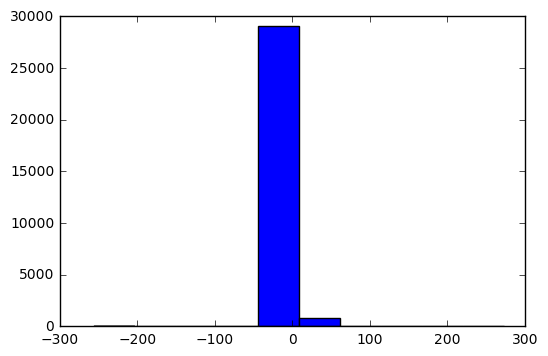

In [14]:
plt.hist(haha)

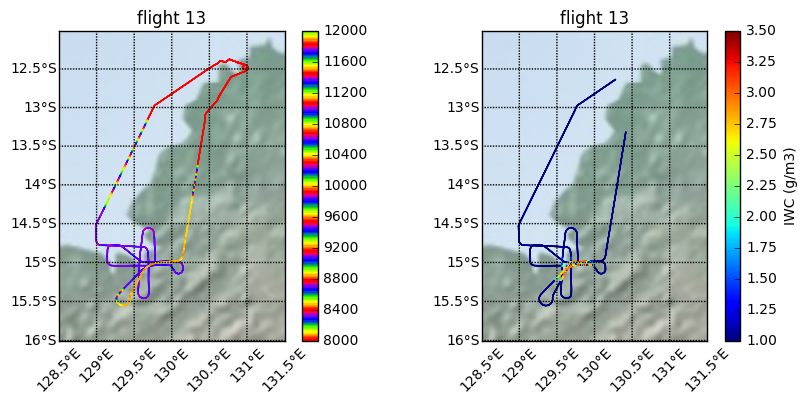

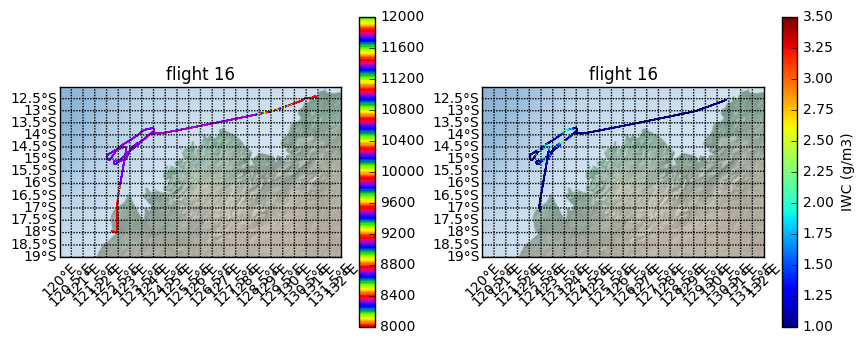

In [6]:
for szi in [13,16]: #range(1,24):
    indflt = dataf.flightnum == szi
    tmp = dataf[indflt]
    
    plt.scatter(tmp.Slong,tmp.Slat,c=tmp.altitude,s=1,linewidths=0,vmin=8e3,vmax=12e3,cmap='prism')
    xl = plt.gca().get_xlim()
    yl = plt.gca().get_ylim()
    plt.close()
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    
    m = Basemap(projection='merc',resolution='c',llcrnrlon=xl[0],llcrnrlat=yl[0],
                urcrnrlon=xl[1],urcrnrlat=yl[1])
    mlon,mlat = m(np.array(tmp.Slong), np.array(tmp.Slat))
    m.shadedrelief()
    ax = m.drawmeridians(np.arange(xl[0],xl[1]+.1,.5),labels=[0,0,0,1])
    m.drawparallels(np.arange(yl[0],yl[1]+.1,.5),labels=[1,0,0,0])
    
    plt.scatter(mlon,mlat,c=tmp.altitude,s=1,linewidths=0,vmin=8e3,vmax=12e3,cmap='prism')
    hcb = plt.colorbar()
    [labels[1][0].set_rotation(45) for labels in ax.values()]
#     hcb.set_label('Alts (m)')
    plt.title('flight '+str(szi))
    

#     plt.subplot(1,3,2)
#     indflt = dataf.flightnum == szi
#     tmp = dataf[indflt]
#     plt.scatter(tmp.Slong,tmp.Slat,c=tmp.altitude,s=.3,linewidths=0,vmin=8e3,vmax=12e3,cmap='jet')
#     hcb = plt.colorbar(label='Alts (m)')
#     plt.xlabel('Long')
#     plt.title('flight '+str(szi))
    
    plt.subplot(1,2,2)
    m.shadedrelief()
    ax = m.drawmeridians(np.arange(xl[0],xl[1]+.1,.5),labels=[0,0,0,1])
    m.drawparallels(np.arange(yl[0],yl[1]+.1,.5),labels=[1,0,0,0])
    [labels[1][0].set_rotation(45) for labels in ax.values()]
    
    plt.scatter(mlon,mlat,c=tmp.iwc,s=1,linewidths=0,vmin=1.,vmax=3.5,cmap='jet')
    hcb = plt.colorbar(label='IWC (g/m3)')
    plt.title('flight '+str(szi))
    
    plt.show()

In [165]:
tmp = dataf[(dataf.flightnum==13) & (dataf.iwc>1.)]

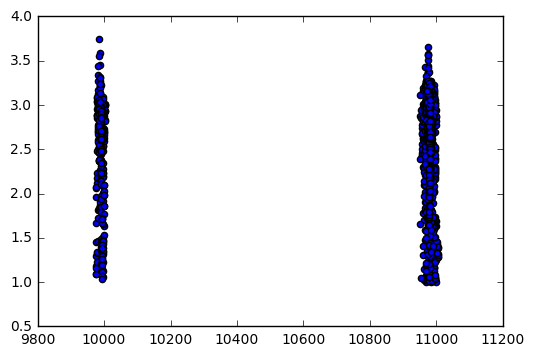

In [167]:
plt.scatter(tmp.altitude,tmp.iwc)

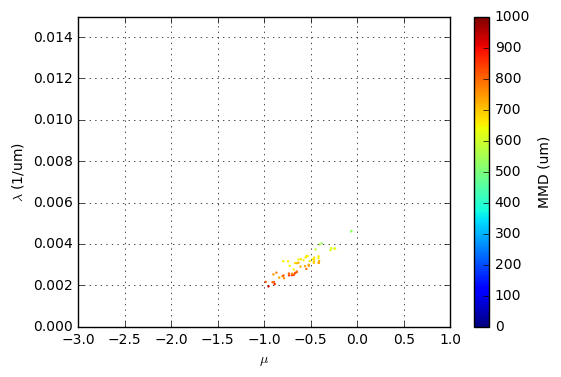

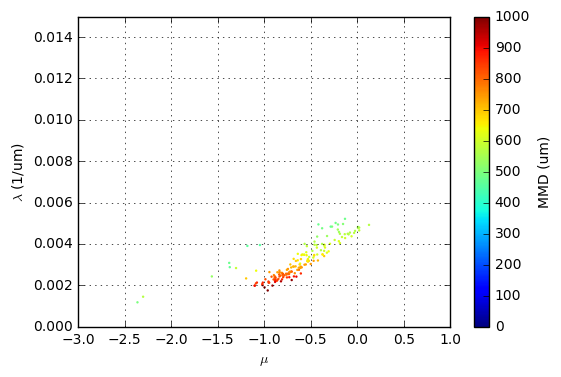

In [179]:
tmp1 = tmp[tmp.altitude<10400]
tmp2 = tmp[tmp.altitude>10400]
collection = {'linewidths':0,'antialiaseds':True}

scatter(tmp1.mu, tmp1.ld, c=tmp1.mmd, s=3, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('$\mu$')
plt.ylabel(r'$\lambda$ (1/um)')
plt.xlim(-3,1)
plt.ylim(0,.015)
plt.clim(0,1000)
plt.grid(b=True)
plt.show()

scatter(tmp2.mu, tmp2.ld, c=tmp2.mmd, s=3, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('$\mu$')
plt.ylabel(r'$\lambda$ (1/um)')
plt.xlim(-3,1)
plt.ylim(0,.015)
plt.clim(0,1000)
plt.grid(b=True)
plt.show()
